# Assignment 2

## Exercise 1: Data Preparation

### 1.1

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, fbeta_score, classification_report

In [7]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [8]:
print('Feature names: \n', data.feature_names)

print('\n Target names: \n', data.target_names, '\n')

print('\n Shape of the dataset: \n', df.shape)

Feature names: 
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

 Target names: 
 ['malignant' 'benign'] 


 Shape of the dataset: 
 (569, 31)


In [9]:
target_counts = df['target'].value_counts()
print(target_counts)
percentages = target_counts / len(df) *100
print(percentages)

target
1    357
0    212
Name: count, dtype: int64
target
1    62.741652
0    37.258348
Name: count, dtype: float64


The dataset contain 569 entries with 30 features. 357 of the cases are benign and 212 are malignant. The dataset is a little unbalanced but it should still perform fairly well. Though having most of the cases in the dataset being bening could potentially be a problem because we would want the model to catch as many malignant cases as possible. And in this case false negatives would be beneficial.

### 1.2

Text(0.5, 0, 'Feature value')

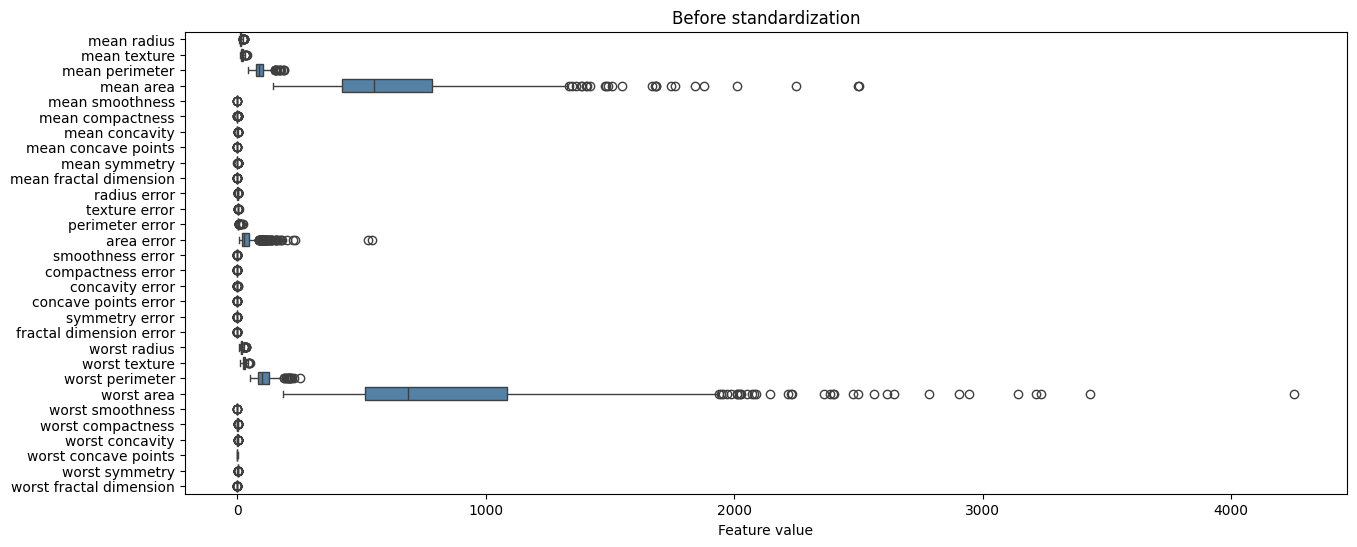

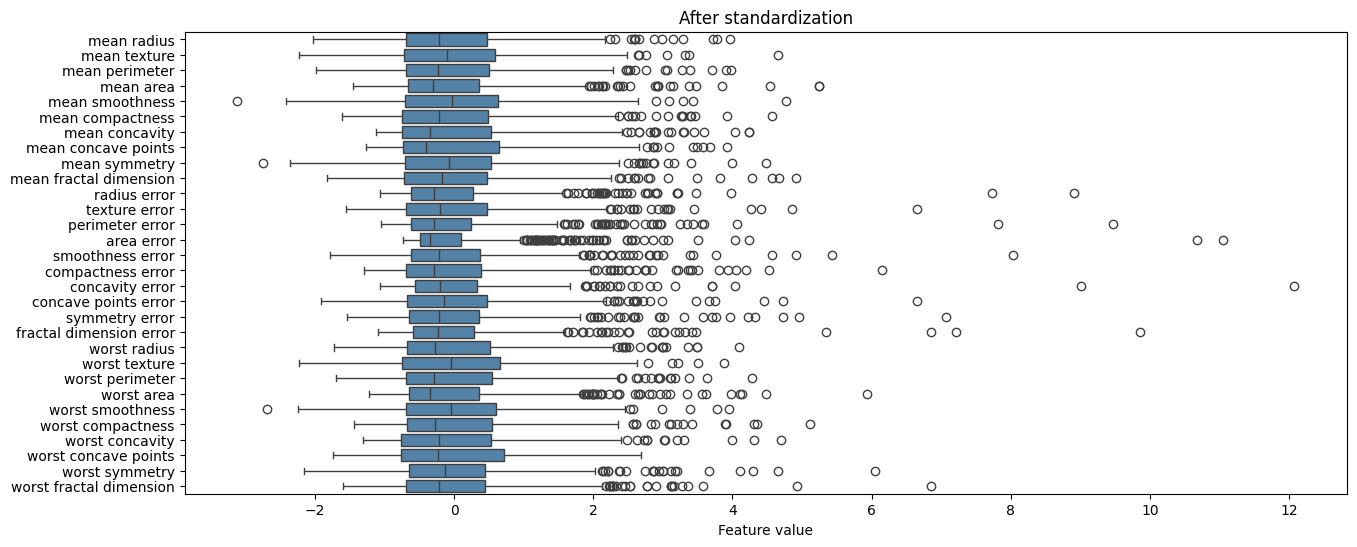

In [10]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

plt.figure(figsize=(15, 6))
sns.boxplot(data=X, orient='h', color='steelblue')
plt.title('Before standardization')
plt.xlabel('Feature value')
plt.show

plt.figure(figsize=(15, 6))
sns.boxplot(data=X_std, orient='h', color='steelblue')
plt.title('After standardization')
plt.xlabel('Feature value')

We can see that some of the values in the dataset before standardization have much larger values. After the standardization the values are very similar. The scale of the dataset does not matter for models like decision trees but it is beneficial to standardize if for when we want to use it with sensitive models like SVM.

### 1.3

Using a three way split allows the model to do hyperparameter tuning using the validation set instead of the training set which could result in false accuracy. Using cross-validation to tune the hyperparameters makes the model more robust as you get more realistic results from the training set. This helps the robustness as the model can perform over different subsets.

## Exercise 2: Decision Trees

### 2.1

In [43]:
X = data.data
y = data.target

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f'Training set: {X_train.shape} \nValidation set: {X_val.shape} \nTest set: {X_test.shape}')

Training set: (341, 30) 
Validation set: (114, 30) 
Test set: (114, 30)


In [12]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

cv_scores = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy: {:.3f} ± {:.3f}".format(cv_scores.mean(), cv_scores.std()))

val_acc = dt_default.score(X_val, y_val)
print("Validation set accuracy: {:.3f}".format(val_acc))

Cross-validation accuracy: 0.906 ± 0.020
Validation set accuracy: 0.965


Here we get a cross-validation of 0.906 ± 0.02 with a validation set accuracy of 0.965. This tells us that the either the cases in the validation set is easier to identify or the model is overfitted. The model is not very robust and could have trouble identifying cases in other subsets.

### 2.2

In [45]:
feature_names = data.feature_names

importance = dt_default.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance.head(10))

                 Feature  Importance
20          worst radius    0.711044
27  worst concave points    0.157981
11         texture error    0.039003
21         worst texture    0.027540
1           mean texture    0.022306
26       worst concavity    0.021558
0            mean radius    0.011651
14      smoothness error    0.005967
10          radius error    0.002951
6         mean concavity    0.000000


Text(0, 0.5, 'Importance')

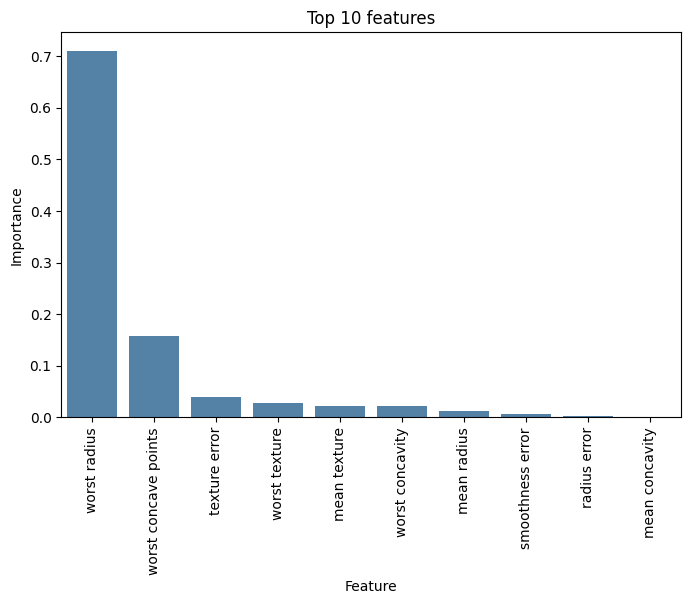

In [51]:
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance['Feature'][:10], y=feature_importance['Importance'][:10], color='steelblue')
plt.xticks(rotation=90)
plt.title('Top 10 features')
plt.ylabel('Importance')

The decision tree model identified the three most important features to be: worst radius, worst concave points and texture error, with worst texture, mean texture, and worst concavity contributing just slightly less.

### 2.3

In [15]:
depths = range(2, 11)
results = []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
    results.append({
        'max_depth': d,
        'mean_acc': scores.mean(),
        'std_acc': scores.std()
    })

results_df = pd.DataFrame(results)
print(results_df)

   max_depth  mean_acc   std_acc
0          2  0.950171  0.025584
1          3  0.935465  0.028854
2          4  0.920801  0.007389
3          5  0.917945  0.014594
4          6  0.915004  0.016851
5          7  0.906181  0.019825
6          8  0.906181  0.019825
7          9  0.906181  0.019825
8         10  0.906181  0.019825


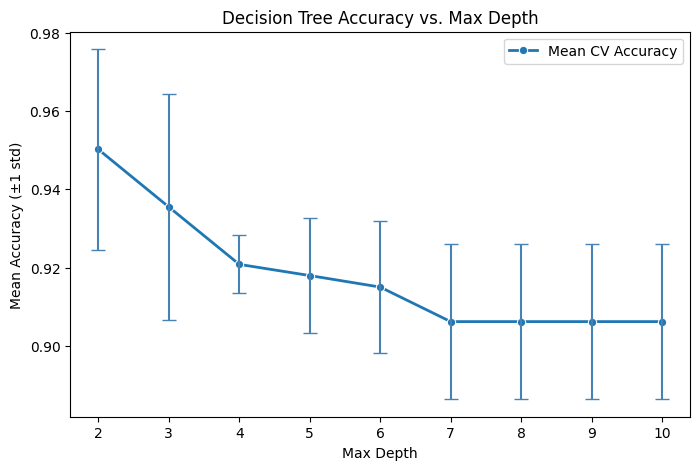

In [16]:
plt.figure(figsize=(8,5))
sns.lineplot(
    data=results_df,
    x='max_depth',
    y='mean_acc',
    marker='o',
    err_style='bars',
    linewidth=2,
    label='Mean CV Accuracy'
)

plt.errorbar(results_df['max_depth'], results_df['mean_acc'],
             yerr=results_df['std_acc'], fmt='none', ecolor='steelblue', capsize=5)

plt.title("Decision Tree Accuracy vs. Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Mean Accuracy (±1 std)")
plt.legend()
plt.show()

At the lower depths(2-3) the model underfits, with an accuracy of 0.94-0.95 it shows that the model is too simple to accurately predict a case. As the the we go deeper(4-6) we can see the model starting to stabilize and the variance is at the lowest, which is good because it is balanced and can make better predictions. When the depth reaches even farther down(7-10) we can see that the addition of layers does not make a difference in the outcome of the predictions since the model becomes too complex to generalize which makes the model overfitted.

### 2.4

In [57]:
leaf_values = [1, 2, 4, 6, 8, 10]
results = []

for leaf in leaf_values:
    dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=leaf, random_state=42)
    scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
    results.append({
        'min_samples_leaf': leaf,
        'mean_acc': scores.mean(),
        'std_acc': scores.std()
    })

results_df = pd.DataFrame(results)
print(results_df)

   min_samples_leaf  mean_acc   std_acc
0                 1  0.917945  0.014594
1                 2  0.912020  0.022788
2                 4  0.920801  0.020015
3                 6  0.935465  0.033047
4                 8  0.941347  0.024610
5                10  0.953069  0.025317


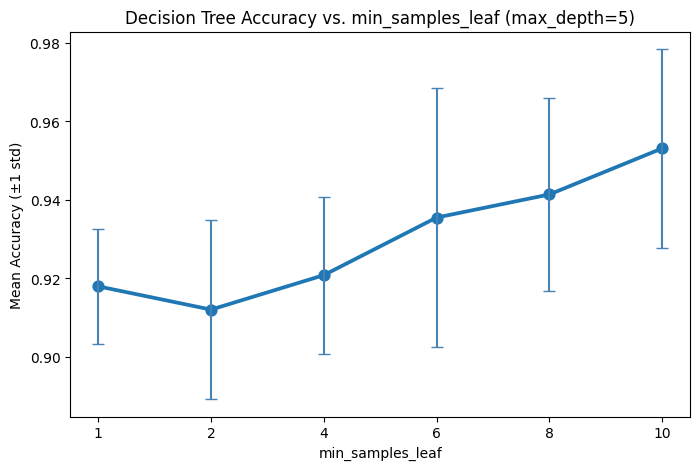

In [58]:
plt.figure(figsize=(8, 5))
sns.pointplot(
    data = results_df,
    x = 'min_samples_leaf',
    y = 'mean_acc',
    errorbar=('sd'),
    capsize=.1,
)
plt.errorbar(
    x=range(len(results_df)),
    y=results_df['mean_acc'],
    yerr=results_df['std_acc'],
    fmt='none',
    ecolor='steelblue',
    capsize=4
)
plt.title("Decision Tree Accuracy vs. min_samples_leaf (max_depth=5)")
plt.xlabel("min_samples_leaf")
plt.ylabel("Mean Accuracy (±1 std)")
plt.show()

From the results we can see that min_leafs=10 is the best generalization since the accuracy is the highest and the deviation is just slightly higher that that of 4.

## Exercise 3: Support Vector Machines (SVM)

### 3.1

In [19]:
X = data.data
y = data.target

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
fprs, tprs, aucs = [], [], []

svm_linear = SVC(kernel='linear', probability=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_std, y_train), 1):
    X_tr, X_val_fold = X_train_std[train_idx], X_train_std[val_idx]
    y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

    svm_linear.fit(X_tr, y_tr)

    y_pred = svm_linear.predict(X_val_fold)
    y_prob = svm_linear.predict_proba(X_val_fold)[:, 1]

    acc = accuracy_score(y_val_fold, y_pred)
    accuracies.append(acc)

    fpr, tpr, _ = roc_curve(y_val_fold, y_prob)
    roc_auc = auc(fpr, tpr)
    
    aucs.append(roc_auc)
    fprs.append(fpr)
    tprs.append(tpr)

    print(f'Fold {fold}: Accuracy = {acc:.3f}, AUC = {roc_auc:.3f}')

mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
    
print(f"\nMean Accuracy: {mean_acc:.3f} ± {std_acc:.3f}")



Fold 1: Accuracy = 0.971, AUC = 0.998
Fold 2: Accuracy = 0.971, AUC = 0.961
Fold 3: Accuracy = 0.941, AUC = 0.967
Fold 4: Accuracy = 0.971, AUC = 0.999
Fold 5: Accuracy = 0.971, AUC = 0.998

Mean Accuracy: 0.965 ± 0.012


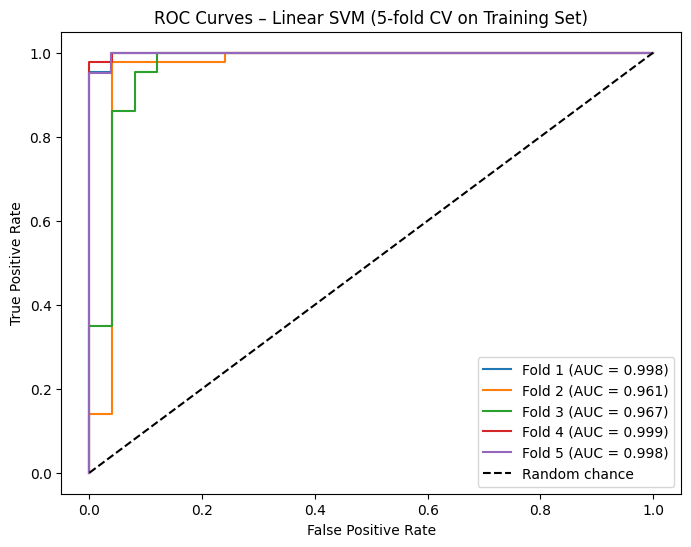

In [20]:
plt.figure(figsize=(8,6))

for i, (fpr, tpr, roc_auc) in enumerate(zip(fprs, tprs, aucs)):
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Linear SVM (5-fold CV on Training Set)")
plt.legend()
plt.show()

The model has a mean accuracy of 0.965 ± 0.012 with AUC values between 0.961-0.999 which show that the model is very good at distinguishing the two classes.

### 3.2

In [21]:
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train_std, y_train)
y_pred_lin = svm_linear.predict(X_val_std)
y_prob_lin = svm_linear.predict_proba(X_val_std)[:, 1]
acc_lin = accuracy_score(y_val, y_pred_lin)

svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train_std, y_train)
y_pred_rbf = svm_rbf.predict(X_val_std)
y_prob_rbf = svm_rbf.predict_proba(X_val_std)[:, 1]
acc_rbf = accuracy_score(y_val, y_pred_rbf)

print(f"Validation Accuracy (Linear): {acc_lin:.3f}")
print(f"Validation Accuracy (RBF): {acc_rbf:.3f}")

Validation Accuracy (Linear): 0.982
Validation Accuracy (RBF): 0.982


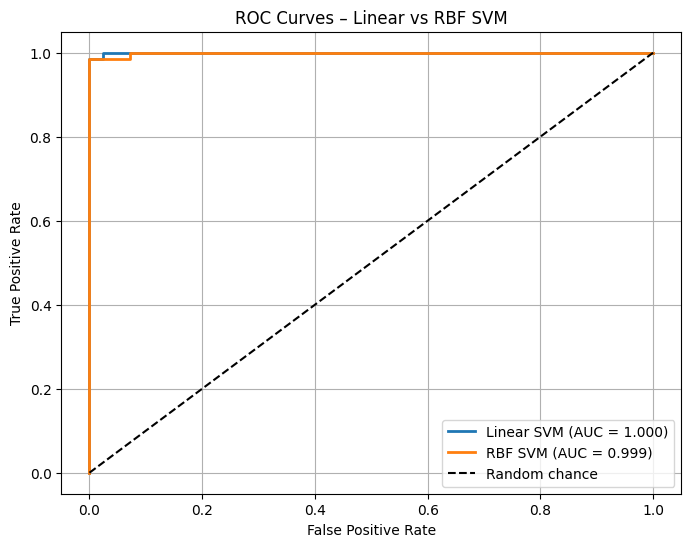

In [22]:
fpr_lin, tpr_lin, _ = roc_curve(y_val, y_prob_lin)
roc_auc_lin = auc(fpr_lin, tpr_lin)

fpr_rbf, tpr_rbf, _ = roc_curve(y_val, y_prob_rbf)
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lin, tpr_lin, label=f'Linear SVM (AUC = {roc_auc_lin:.3f})', lw=2)
plt.plot(fpr_rbf, tpr_rbf, label=f'RBF SVM (AUC = {roc_auc_rbf:.3f})', lw=2)
plt.plot([0,1],[0,1],'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Linear vs RBF SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

We can see that the RBF model performs slightly better than the SVM model due to RBF being able to capture some nonlinear relationships. There is not a very big difference in this case and the SVM preforms almost just as well.

### 3.3

In [23]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
acc_scores = []

for C in C_values:
    svm_rbf = SVC(kernel='rbf', C=C, probability=True, random_state=42)
    svm_rbf.fit(X_train_std, y_train)
    y_pred = svm_rbf.predict(X_val_std)
    acc = accuracy_score(y_val, y_pred)
    acc_scores.append(acc)
    print(f"C={C}: Validation Accuracy = {acc:.3f}")

C=0.001: Validation Accuracy = 0.632
C=0.01: Validation Accuracy = 0.632
C=0.1: Validation Accuracy = 0.965
C=1: Validation Accuracy = 0.982
C=10: Validation Accuracy = 0.974
C=100: Validation Accuracy = 0.965
C=1000: Validation Accuracy = 0.965


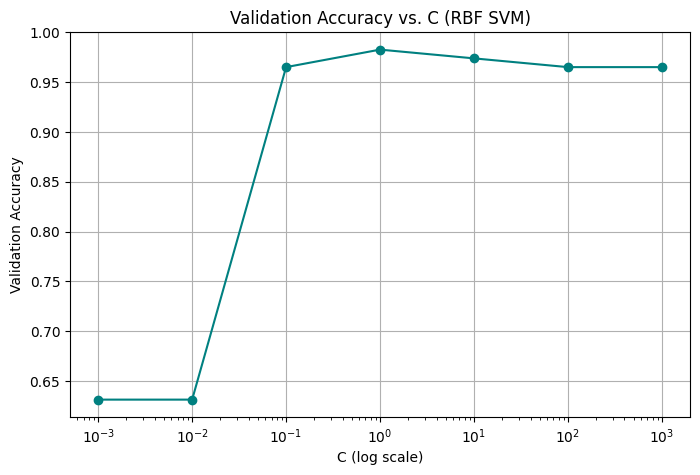

In [24]:
plt.figure(figsize=(8,5))
plt.semilogx(C_values, acc_scores, marker='o', linestyle='-', color='teal')
plt.title("Validation Accuracy vs. C (RBF SVM)")
plt.xlabel("C (log scale)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

We can see a big increase in accuracy going from 0.001 to 0.1 where it stabilizes with the optimal value being 1 as the accuracy declines slightly and flattens after.

### 3.4

In [25]:
gamma_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
acc_scores = []

for g in gamma_values:
    svm_rbf = SVC(kernel='rbf', C=1, gamma=g, probability=True, random_state=42)
    svm_rbf.fit(X_train_std, y_train)
    y_pred = svm_rbf.predict(X_val_std)
    acc = accuracy_score(y_val, y_pred)
    acc_scores.append(acc)
    print(f"γ={g}: Validation Accuracy = {acc:.3f}")

γ=0.0001: Validation Accuracy = 0.702
γ=0.001: Validation Accuracy = 0.965
γ=0.01: Validation Accuracy = 0.982
γ=0.1: Validation Accuracy = 0.982
γ=1: Validation Accuracy = 0.632
γ=10: Validation Accuracy = 0.632


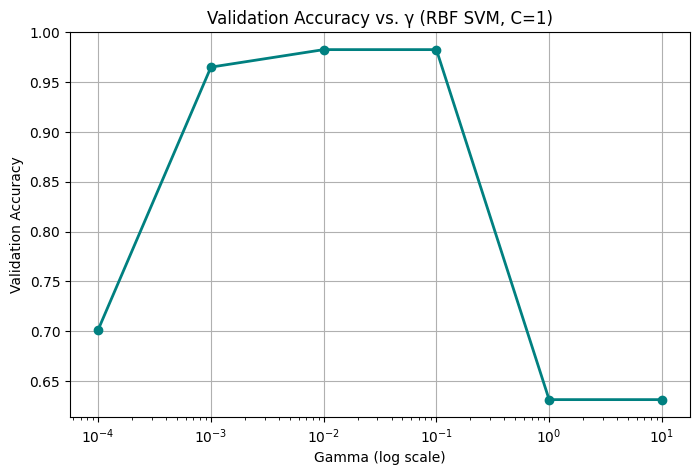

In [26]:
plt.figure(figsize=(8,5))
plt.semilogx(gamma_values, acc_scores, marker='o', color='teal', linewidth=2)
plt.title("Validation Accuracy vs. γ (RBF SVM, C=1)")
plt.xlabel("Gamma (log scale)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

Too small gamma value the model is unable to capture the complexities of the data. At around 0.01-0.1 the gamma value is more flexible and gives us the best result with accuracy at 0.982.

## Exercise-4: Model Comparison

### 4.1

In [60]:
dt_best = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
svm_best = SVC(kernel='rbf', C=1, gamma=0.01, probability=True, random_state=42)

dt_cv = cross_val_score(dt_best, X_train_std, y_train, cv=5, scoring='accuracy')
svm_cv = cross_val_score(svm_best, X_train_std, y_train, cv=5, scoring='accuracy')

dt_best.fit(X_train_std, y_train)
svm_best.fit(X_train_std, y_train)

y_pred_dt = dt_best.predict(X_val_std)
y_pred_svm = svm_best.predict(X_val_std)

y_prob_dt = dt_best.predict_proba(X_val_std)[:, 1]
y_prob_svm = svm_best.predict_proba(X_val_std)[:, 1]

val_acc_dt = accuracy_score(y_val, y_pred_dt)
val_acc_svm = accuracy_score(y_val, y_pred_svm)

print("Decision Tree: CV = {:.3f} ± {:.3f}, Validation = {:.3f}".format(
    dt_cv.mean(), dt_cv.std(), val_acc_dt))
print("SVM (RBF):     CV = {:.3f} ± {:.3f}, Validation = {:.3f}".format(
    svm_cv.mean(), svm_cv.std(), val_acc_svm))

Decision Tree: CV = 0.953 ± 0.025, Validation = 0.956
SVM (RBF):     CV = 0.959 ± 0.020, Validation = 0.982


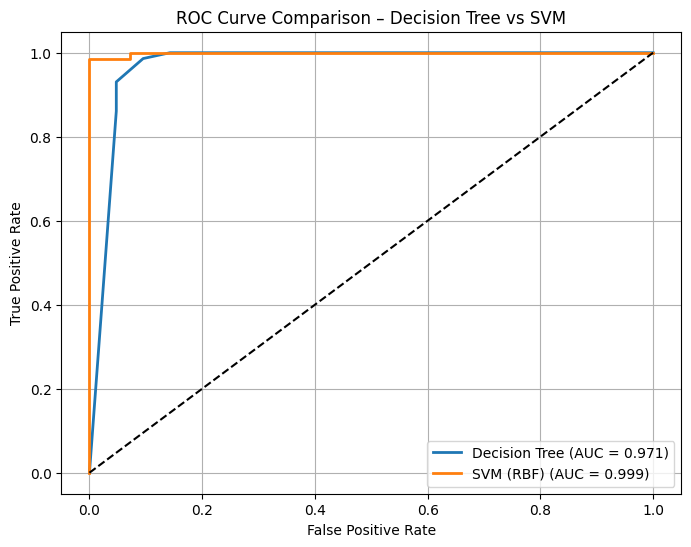

In [61]:
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_prob_dt)
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_prob_svm)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})', lw=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (RBF) (AUC = {roc_auc_svm:.3f})', lw=2)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison – Decision Tree vs SVM')
plt.legend()
plt.grid(True)
plt.show()

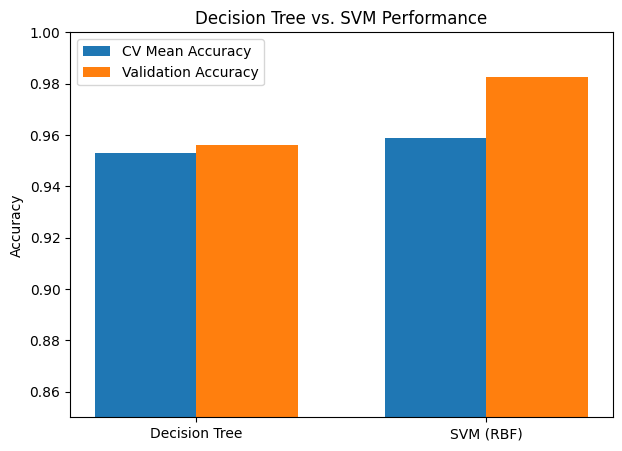

In [62]:
models = ['Decision Tree', 'SVM (RBF)']
cv_means = [dt_cv.mean(), svm_cv.mean()]
val_accs = [val_acc_dt, val_acc_svm]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, cv_means, width, label='CV Mean Accuracy')
plt.bar(x + width/2, val_accs, width, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.title('Decision Tree vs. SVM Performance')
plt.xticks(x, models)
plt.legend()
plt.ylim(0.85, 1.0)
plt.show()

Decision Tree: CV = 0.953 ± 0.025, Validation = 0.956 <br>
SVM (RBF):     CV = 0.959 ± 0.020, Validation = 0.982 

Both models perform well, but SVM performs slightly better with higher accuracy and lower deviation and higher validation accuracy which indicates better generalization.

### 4.2

In [63]:
prec_dt = precision_score(y_val, y_pred_dt)
rec_dt = recall_score(y_val, y_pred_dt)
f2_dt = fbeta_score(y_val, y_pred_dt, beta=2)

prec_svm = precision_score(y_val, y_pred_svm)
rec_svm = recall_score(y_val, y_pred_svm)
f2_svm = fbeta_score(y_val, y_pred_svm, beta=2)

print("Decision Tree → Precision: {:.3f}, Recall: {:.3f}, F2: {:.3f}".format(prec_dt, rec_dt, f2_dt))
print("SVM (RBF)     → Precision: {:.3f}, Recall: {:.3f}, F2: {:.3f}".format(prec_svm, rec_svm, f2_svm))

Decision Tree → Precision: 0.947, Recall: 0.986, F2: 0.978
SVM (RBF)     → Precision: 0.986, Recall: 0.986, F2: 0.986


The decision tree model is good if you need to interpret the results but the with a lower accuracy it would likely miss more malignant cases which is not good. The SMV model would be the best model to use for medical support-system as the presicion is better at catching those malignant cases which ultimately is what we want.

### 4.3

In [64]:
dt_param_grid = {
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)

print("Best Decision Tree Parameters:", dt_grid.best_params_)
print("Best Cross-val Accuracy:", dt_grid.best_score_)

Best Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2}
Best Cross-val Accuracy: 0.9413043478260871


In [65]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

svm = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_std, y_train)

print("Best SVM Parameters:", svm_grid.best_params_)
print("Best Cross-val Accuracy:", svm_grid.best_score_)

Best SVM Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best Cross-val Accuracy: 0.9735720375106565


In [66]:
dt_best = dt_grid.best_estimator_
svm_best = svm_grid.best_estimator_

y_pred_dt = dt_best.predict(X_val)
y_pred_svm = svm_best.predict(X_val_std)

val_acc_dt = accuracy_score(y_val, y_pred_dt)
val_acc_svm = accuracy_score(y_val, y_pred_svm)

print(f"Decision Tree Validation Accuracy: {val_acc_dt:.3f}")
print(f"SVM Validation Accuracy: {val_acc_svm:.3f}")

Decision Tree Validation Accuracy: 0.956
SVM Validation Accuracy: 0.974


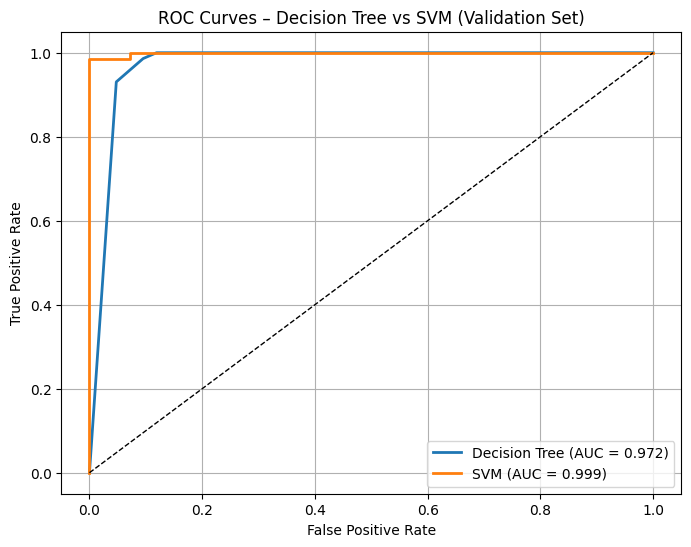

In [67]:
y_prob_dt = dt_best.predict_proba(X_val)[:, 1]
y_prob_svm = svm_best.predict_proba(X_val_std)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_val, y_prob_dt)
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_prob_svm)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})", lw=2)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.3f})", lw=2)
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Decision Tree vs SVM (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

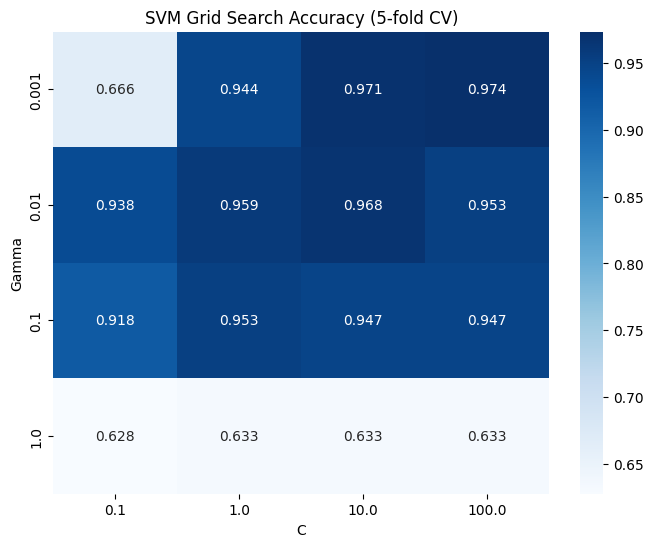

In [68]:
results = pd.DataFrame(svm_grid.cv_results_)
pivot = results.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Blues")
plt.title("SVM Grid Search Accuracy (5-fold CV)")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.show()

The best settings looks to be: Decision tree(gini, max_depth=3, min_samples_leaf=2), SVM(C=100, gamma=0.001)

### 4.4

In [69]:
X_test_std = scaler.transform(X_test)

dt_best = DecisionTreeClassifier(
    criterion='entropy', max_depth=5, min_samples_leaf=4, random_state=42
)
svm_best = SVC(
    kernel='rbf', C=100, gamma=0.01, probability=True, random_state=42
)

dt_best.fit(X_train, y_train)
svm_best.fit(X_train_std, y_train)

y_pred_dt = dt_best.predict(X_test)
y_pred_svm = svm_best.predict(X_test_std)

test_acc_dt = accuracy_score(y_test, y_pred_dt)
test_acc_svm = accuracy_score(y_test, y_pred_svm)

y_prob_dt = dt_best.predict_proba(X_test)[:, 1]
y_prob_svm = svm_best.predict_proba(X_test_std)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print(f"Decision Tree → Test Accuracy = {test_acc_dt:.3f}, AUC = {roc_auc_dt:.3f}")
print(f"SVM (RBF)     → Test Accuracy = {test_acc_svm:.3f}, AUC = {roc_auc_svm:.3f}")

Decision Tree → Test Accuracy = 0.930, AUC = 0.974
SVM (RBF)     → Test Accuracy = 0.939, AUC = 0.993


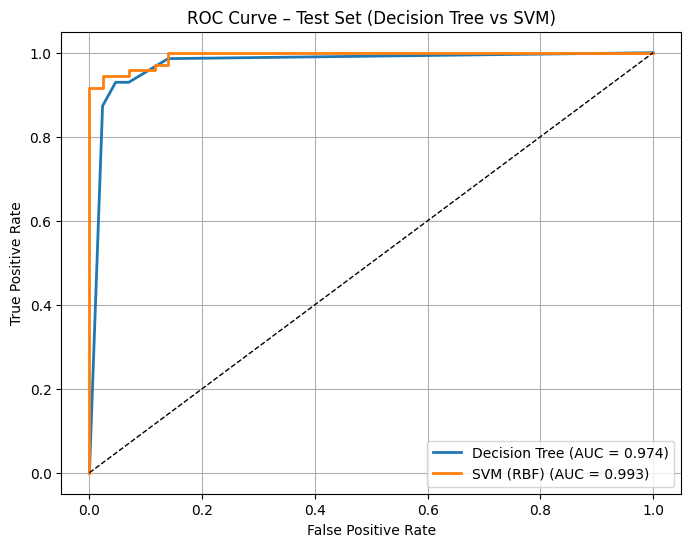

In [70]:
plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})", lw=2)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (RBF) (AUC = {roc_auc_svm:.3f})", lw=2)
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test Set (Decision Tree vs SVM)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [71]:
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("SVM (RBF) Classification Report:\n", classification_report(y_test, y_pred_svm))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        43
           1       0.96      0.93      0.94        71

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114

SVM (RBF) Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92        43
           1       0.93      0.97      0.95        71

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



The SVM model generalizes better with more robust performance. The decision tree performs worse but is still good and provides better interpretability.

### 4.5